# Pandas II – Data Wrangling (Daten "rumschubsen")

In [1]:
import pandas as pd
import numpy as np
import biopsykit as bp

## Einführung

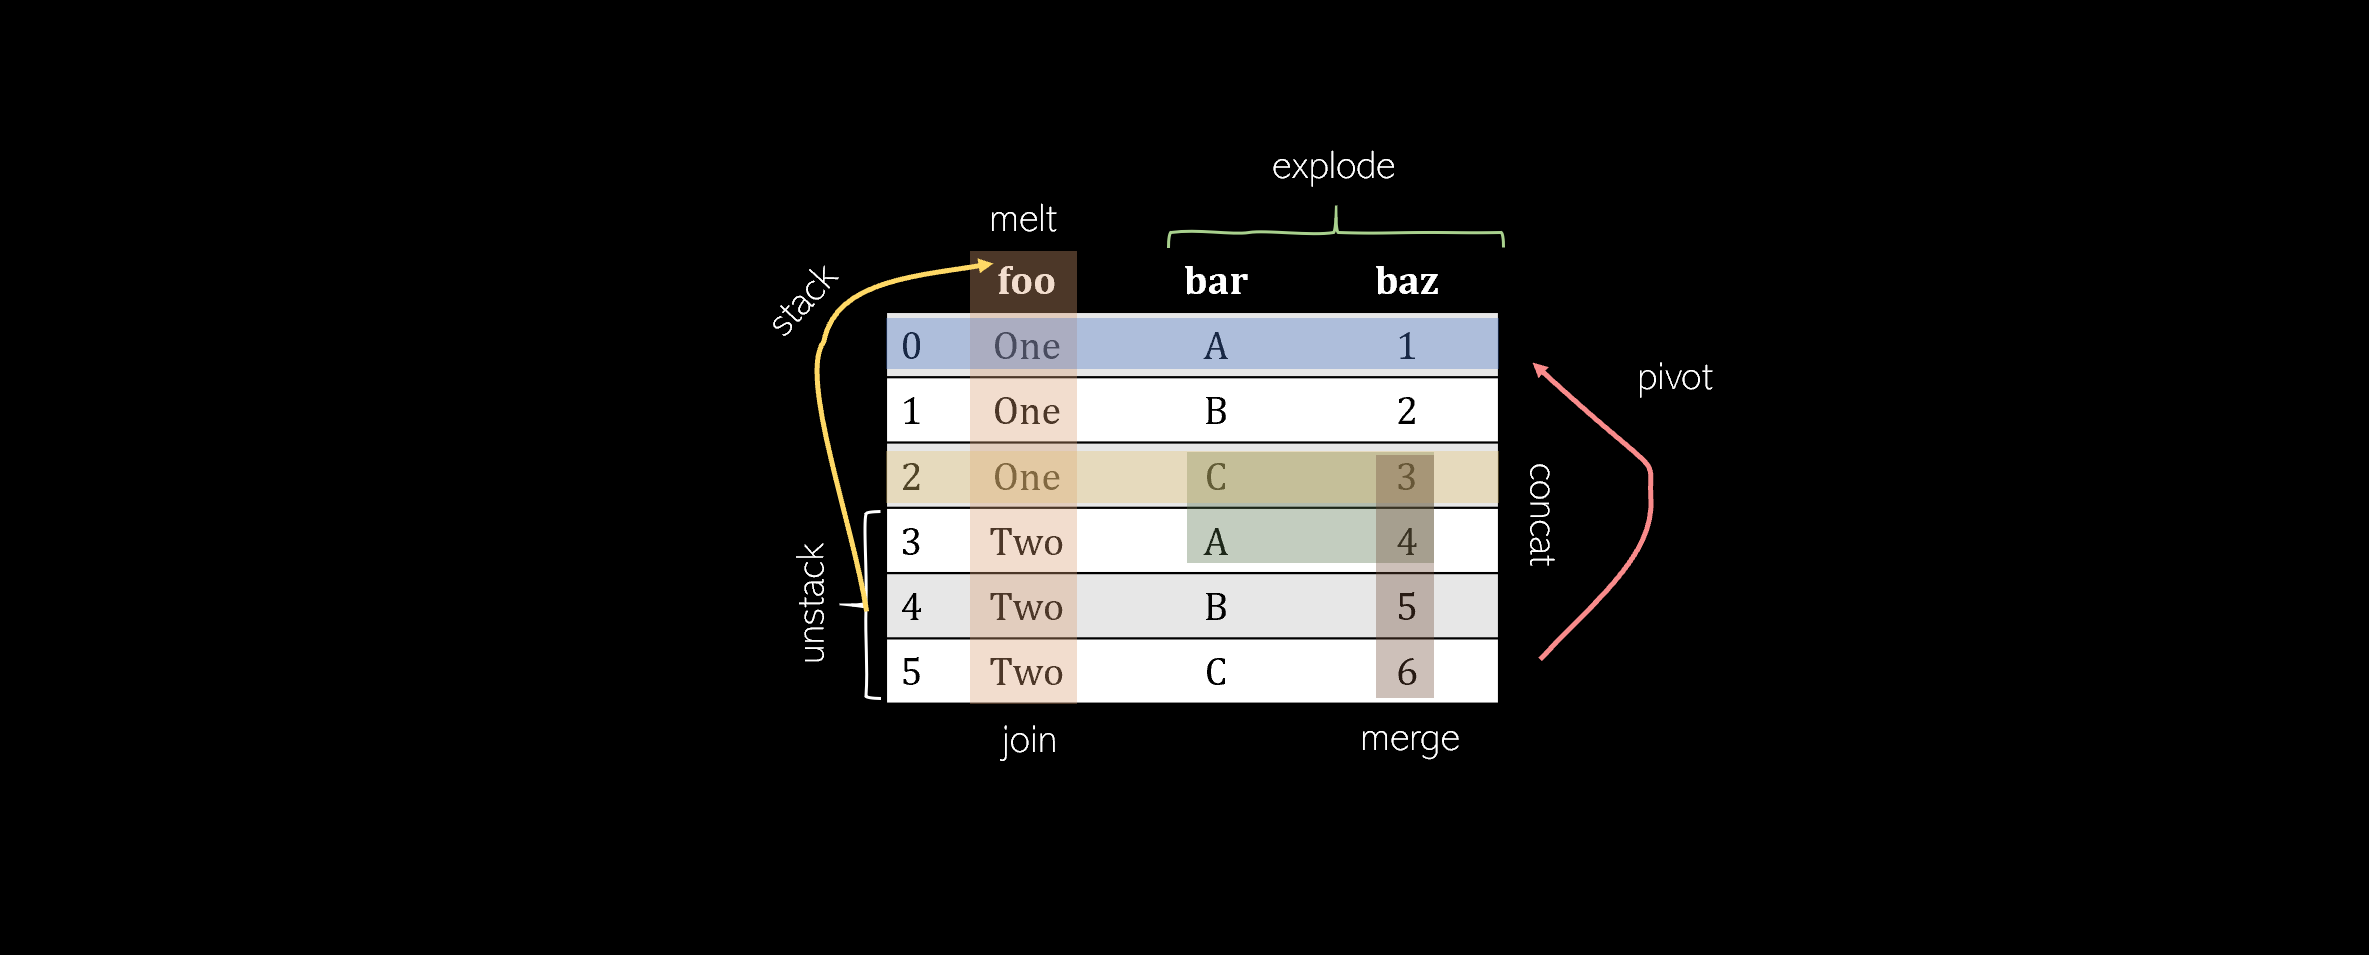

In [2]:
from IPython.display import Image
Image("img/img_pandas_functions.png")

Laden eines `DataFrames` von einer `csv`-Datei:

In [3]:
pd.read_csv('data/cortisol_sample.csv').head()

,subject,condition,0,1,2,3,4,5,6
0,1,Intervention,6.98890,7.03320,5.77670,5.25790,5.00795,4.50045,4.06615
1,2,Intervention,5.10235,5.61940,5.02540,4.89695,5.45370,5.07690,4.10855
2,3,Control,5.39850,13.27400,10.10115,14.23000,13.98650,12.03900,11.00850
3,4,Intervention,3.13210,2.72265,2.32200,2.04720,1.91595,2.00425,1.82235
4,5,Intervention,8.38690,8.13245,6.64140,5.40945,4.99895,4.93540,4.94870


Beim Laden des Speichelproben-Beispiel-Datensatzes in `BioPsyKit` fällt allerdings auf, dass der resultierende `DataFrame` nicht so aussieht, sondern anders aufgebaut ist:

In [6]:
bp.example_data.get_saliva_example()

cortisol
subject condition    sample          
01      Intervention 0        6.98890
                     1        7.03320
                     2        5.77670
                     3        5.25790
                     4        5.00795
...                               ...
33      Control      2        7.78115
                     3        8.74815
                     4        7.66505
                     5        7.75460
                     6        6.72890

[196 rows x 1 columns]

Das liegt daran, dass der `DataFrame` vom herkömmlichen *Wide-Format* (oder *Panel/Table-Format*) in das *Long-Format* konvertiert wurde.

Aus Wikipedia (https://de.wikipedia.org/wiki/Wide-Format_und_Long-Format):

* Das *Wide-Format* eignet sich gut für die Darstellung von Querschnittsdaten oder Zeitreihendaten. Im Wide-Format enthalten mehrere Spalten die Messwerte der gleichen Variable zu unterschiedlichen Zeitpunkten oder Messwiederholungen (hier zum Beispiel unterschiedliche Speichelmessungen), während ein Subject eine Zeile der Tabelle entspricht.

* Im *Long-Format* werden alle Werte der messwiederholten Variable in der *gleichen* Spalte und der zugehörige Zeitpunkt in einer *eigenen* Variable dargestellt. Daher werden die Daten im *Long-Format* auch als "gestapelt" (*stacked*) bezeichnet. Weitere Variablen werden in einer eigenen Spalte notiert, nutzen jedoch ebenfalls die Werte der Zeitvariable. Die Zeitvariable (oder *Indexvariable*), die auch die Versuchswiederholung oder den Kontext der Messung angeben kann, ist somit explizit angegeben.

<b>
Viele Statistik- und Plotbibliotheken erfordern für einige Operationen, insbesondere bei der Analyse von Paneldaten, dass ein <i>Long-Format</i> verwendet wird, in dem der Zeitpunkt explizit angegeben ist. Deshalb ist die Transformation von Daten im <i>Wide-Format</i> ins <i>Long-Format</i> von großer Bedeutung.
</b>

<div class="alert alert-block alert-info">
    <b>Hinweis:</b> In pandas <code>DataFrames</code> im <i>Long-Format</i> werden die Indexvariablen als <code>MultiIndex</code> gespeichert.
</div>

## Umwandlung vom *Wide-* ins *Long-Format*

### Umwandeln manuell

DataFrame laden

In [7]:
data = pd.read_csv('data/cortisol_sample.csv')
data.head()

,subject,condition,0,1,2,3,4,5,6
0,1,Intervention,6.98890,7.03320,5.77670,5.25790,5.00795,4.50045,4.06615
1,2,Intervention,5.10235,5.61940,5.02540,4.89695,5.45370,5.07690,4.10855
2,3,Control,5.39850,13.27400,10.10115,14.23000,13.98650,12.03900,11.00850
3,4,Intervention,3.13210,2.72265,2.32200,2.04720,1.91595,2.00425,1.82235
4,5,Intervention,8.38690,8.13245,6.64140,5.40945,4.99895,4.93540,4.94870


Index setzen 

In [8]:
index_cols = ['subject', 'condition']
data.set_index(index_cols, inplace=True)
# kann auch direkt beim Laden der csv-Datei übergeben werden: pd.read_csv('', index_col=index_cols)

data.head()

,,0,1,2,3,4,5,6
subject,condition,,,,,,,
1,Intervention,6.98890,7.03320,5.77670,5.25790,5.00795,4.50045,4.06615
2,Intervention,5.10235,5.61940,5.02540,4.89695,5.45370,5.07690,4.10855
3,Control,5.39850,13.27400,10.10115,14.23000,13.98650,12.03900,11.00850
4,Intervention,3.13210,2.72265,2.32200,2.04720,1.91595,2.00425,1.82235
5,Intervention,8.38690,8.13245,6.64140,5.40945,4.99895,4.93540,4.94870


#### *Stacken* der Werte

Der *Wide-Format* DataFrame kann theoretisch bereits jetzt ins *Long-Format* gebracht werden. Mittels `DataFrame.stack()` werden die Werte "aufeinander" gestapelt:

In [9]:
pd.DataFrame(data.stack())

0
subject condition              
1       Intervention 0  6.98890
                     1  7.03320
                     2  5.77670
                     3  5.25790
                     4  5.00795
...                         ...
33      Control      2  7.78115
                     3  8.74815
                     4  7.66505
                     5  7.75460
                     6  6.72890

[196 rows x 1 columns]

Was auffällt: Die Wertespalte hat nun keinen Namen (gewünscht wäre z.B. `cortisol`), das neue Index-Level ebenfalls nicht (gewünscht wäre z.B. `sample`). Außerdem sind die Index-Level der Speichelproben noch vom Typ `str`, für spätere Operationen wären jedoch Index-Werte vom Typ `int` hilfreich.

All diese Operationen können entweder nach dem Stacken des DataFrames angewendet werden oder davor.

#### Umwandeln der Spaltennamen von `str` in `int`

In [12]:
data.columns = data.columns.astype(int)

#### Umwandeln der Spalten von einem `Index` in einen `MultiIndex`

Damit der DataFrame später ins *Wide-Format* umgewandelt werden kann, müssen die Spalten als `MultiIndex` notiert sein. So kann später ein Index-Level direkt als Zeitvariable in Spalte umgeschrieben werden.

In diesem Fall wollen wir ein neues Index-Level erzeugen, welcher aus einem einzelnen Wert ('cortisol') für jeden Index-Eintrag besteht. Aus [0, 1, ..., 6] wollen wir also folgenden `MultiIndex` erzeugen: [('cortisol', 0), ('cortisol', 1), ..., ('cortisol', 6)], wobei das zweite Index-Level (name: `sample`) dann die neue Spalte im *Wide-Format* wird.

Ein `MultiIndex` kann auf mehreren Arten *manuell* konstruiert werden:
* `pd.MultiIndex.from_arrays()`
* `pd.MultiIndex.from_tuples()`
* `pd.MultiIndex.from_product()`
* ...

Weitere Informationen: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html

Für unseren Fall eignet sich `pd.MultiIndex.from_product()`:

In [13]:
# Spaltenindex davor:
old_index = data.columns
old_index

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [16]:
# Spaltenindex danach:
new_index = pd.MultiIndex.from_product([['cortisol'], data.columns], names=["", "sample"])
new_index

MultiIndex([('cortisol', 0),
            ('cortisol', 1),
            ('cortisol', 2),
            ('cortisol', 3),
            ('cortisol', 4),
            ('cortisol', 5),
            ('cortisol', 6)],
           names=['', 'sample'])

#### Setzen des MultiIndex als neuen Spaltenindex

In [17]:
data.columns = new_index
data.head()

cortisol                                          \
sample                      0         1         2         3         4   
subject condition                                                       
1       Intervention  6.98890   7.03320   5.77670   5.25790   5.00795   
2       Intervention  5.10235   5.61940   5.02540   4.89695   5.45370   
3       Control       5.39850  13.27400  10.10115  14.23000  13.98650   
4       Intervention  3.13210   2.72265   2.32200   2.04720   1.91595   
5       Intervention  8.38690   8.13245   6.64140   5.40945   4.99895   

                                          
sample                       5         6  
subject condition                         
1       Intervention   4.50045   4.06615  
2       Intervention   5.07690   4.10855  
3       Control       12.03900  11.00850  
4       Intervention   2.00425   1.82235  
5       Intervention   4.93540   4.94870

#### Fertiger *Long-Format*-DataFrame

In [18]:
data_long = data.stack()
data_long

cortisol
subject condition    sample          
1       Intervention 0        6.98890
                     1        7.03320
                     2        5.77670
                     3        5.25790
                     4        5.00795
...                               ...
33      Control      2        7.78115
                     3        8.74815
                     4        7.66505
                     5        7.75460
                     6        6.72890

[196 rows x 1 columns]

Nun sieht der *Wide-Format*-DataFrame exakt so aus wie der von `salvia.io.load_salvia` zurückgegebene DataFrame:

In [20]:
bp.saliva.io.load_saliva(file_path='data/cortisol_sample.csv', biomarker_type='cortisol')

cortisol
subject condition    sample          
01      Intervention 0        6.98890
                     1        7.03320
                     2        5.77670
                     3        5.25790
                     4        5.00795
...                               ...
33      Control      2        7.78115
                     3        8.74815
                     4        7.66505
                     5        7.75460
                     6        6.72890

[196 rows x 1 columns]

### Umwandeln mittels `DataFrame.melt()`

Mit `DataFrame.melt()` kann man einen DataFrame recht einfach vom *Wide-* ins *Long-Format* umwandeln.

Dokumentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html

In [21]:
data = pd.read_csv('data/cortisol_sample.csv')
data.head()

,subject,condition,0,1,2,3,4,5,6
0,1,Intervention,6.98890,7.03320,5.77670,5.25790,5.00795,4.50045,4.06615
1,2,Intervention,5.10235,5.61940,5.02540,4.89695,5.45370,5.07690,4.10855
2,3,Control,5.39850,13.27400,10.10115,14.23000,13.98650,12.03900,11.00850
3,4,Intervention,3.13210,2.72265,2.32200,2.04720,1.91595,2.00425,1.82235
4,5,Intervention,8.38690,8.13245,6.64140,5.40945,4.99895,4.93540,4.94870


In [31]:
data_long = data.melt(id_vars=['condition', 'subject'], value_name='cortisol', var_name="sample")
data_long.head()

,condition,subject,sample,cortisol
0,Intervention,1,0,6.98890
1,Intervention,2,0,5.10235
2,Control,3,0,5.39850
3,Intervention,4,0,3.13210
4,Intervention,5,0,8.38690


Setzen der Index-Spalten und Sortieren des Index

In [32]:
data_long = data_long.set_index(['subject', 'condition', 'sample'])
data_long = data_long.sort_index()

In [33]:
data_long

cortisol
subject condition    sample          
1       Intervention 0        6.98890
                     1        7.03320
                     2        5.77670
                     3        5.25790
                     4        5.00795
...                               ...
33      Control      2        7.78115
                     3        8.74815
                     4        7.66505
                     5        7.75460
                     6        6.72890

[196 rows x 1 columns]

### Umwandeln mittels `pd.wide_to_long()`

Mittels `pd.wide_to_long()` kann ein DataFrame ebenfalls ins *Wide-Format* umgewandelt werden. Diese Funktion ist zwar nutzerfreundlicher als `DataFrame.melt()`, aber weniger flexibel. So erwartet `wide_to_long` z.B. Spalten im Format `A-suffix1`, `A-suffix2`, `...`.

In [34]:
data = pd.read_csv('data/cortisol_sample.csv')
data.head()

,subject,condition,0,1,2,3,4,5,6
0,1,Intervention,6.98890,7.03320,5.77670,5.25790,5.00795,4.50045,4.06615
1,2,Intervention,5.10235,5.61940,5.02540,4.89695,5.45370,5.07690,4.10855
2,3,Control,5.39850,13.27400,10.10115,14.23000,13.98650,12.03900,11.00850
3,4,Intervention,3.13210,2.72265,2.32200,2.04720,1.91595,2.00425,1.82235
4,5,Intervention,8.38690,8.13245,6.64140,5.40945,4.99895,4.93540,4.94870


In [35]:
data.set_index(["subject", "condition"], inplace=True)
data.columns = ["cortisol_{}".format(column) for column in data.columns]
data = data.reset_index()
data.head()

,subject,condition,cortisol_0,cortisol_1,cortisol_2,cortisol_3,cortisol_4,cortisol_5,cortisol_6
0,1,Intervention,6.98890,7.03320,5.77670,5.25790,5.00795,4.50045,4.06615
1,2,Intervention,5.10235,5.61940,5.02540,4.89695,5.45370,5.07690,4.10855
2,3,Control,5.39850,13.27400,10.10115,14.23000,13.98650,12.03900,11.00850
3,4,Intervention,3.13210,2.72265,2.32200,2.04720,1.91595,2.00425,1.82235
4,5,Intervention,8.38690,8.13245,6.64140,5.40945,4.99895,4.93540,4.94870


In [36]:
data_long = pd.wide_to_long(data, stubnames="cortisol", i=['subject', 'condition'], j="sample", sep='_')
data_long

cortisol
subject condition    sample          
1       Intervention 0        6.98890
                     1        7.03320
                     2        5.77670
                     3        5.25790
                     4        5.00795
...                               ...
33      Control      2        7.78115
                     3        8.74815
                     4        7.66505
                     5        7.75460
                     6        6.72890

[196 rows x 1 columns]

### Weitere Beispiele

DataFrame im *Long-Format* laden:

In [37]:
data = bp.saliva.io.load_saliva('data/cortisol_sample.csv', biomarker_type='cortisol')
data

cortisol
subject condition    sample          
01      Intervention 0        6.98890
                     1        7.03320
                     2        5.77670
                     3        5.25790
                     4        5.00795
...                               ...
33      Control      2        7.78115
                     3        8.74815
                     4        7.66505
                     5        7.75460
                     6        6.72890

[196 rows x 1 columns]

Berechnung einiger Standard-Parameter (Ort des Cortisol-Maximums, Mittelwert, Standardabweichung, ...) aus Speicheldaten (mehr dazu später mehr...):

In [38]:
data_features = bp.saliva.standard_features(data)
data_features.head()

,biomarker,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,condition,,,,,
01,Intervention,1.0,5.518750,1.154511,0.363326,-1.319002
02,Intervention,1.0,5.040464,0.483111,-1.132776,2.277321
03,Control,3.0,11.433950,3.067825,-1.433263,2.214301
04,Intervention,0.0,2.280929,0.482352,1.089307,0.063692
05,Intervention,0.0,6.207607,1.524455,0.739954,-1.598975


In [39]:
data_features = data_features.reset_index()
data_features.head()

biomarker,subject,condition,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
0,01,Intervention,1.0,5.518750,1.154511,0.363326,-1.319002
1,02,Intervention,1.0,5.040464,0.483111,-1.132776,2.277321
2,03,Control,3.0,11.433950,3.067825,-1.433263,2.214301
3,04,Intervention,0.0,2.280929,0.482352,1.089307,0.063692
4,05,Intervention,0.0,6.207607,1.524455,0.739954,-1.598975


#### Umwandeln des DataFrames in *Long-Format* mittels `DataFrame.melt()`

In [40]:
data_long = data_features.melt(
    id_vars=['condition', 'subject'], 
    value_vars=['cortisol_argmax', 'cortisol_kurt', 'cortisol_mean', 'cortisol_skew', 'cortisol_std'], 
    var_name="feature", 
    value_name="cortisol"
)
# alternativ: keine Angabe der 'value_vars', dann werden alle Spalten gestacked:
# df_melt = data_features.melt(id_vars=['condition', 'subject'])
data_long.head()

,condition,subject,feature,cortisol
0,Intervention,01,cortisol_argmax,1.0
1,Intervention,02,cortisol_argmax,1.0
2,Control,03,cortisol_argmax,3.0
3,Intervention,04,cortisol_argmax,0.0
4,Intervention,05,cortisol_argmax,0.0


Index setzen und sortieren zur besseren Übersichtlichkeit:

In [41]:
data_long = data_long.set_index(['subject', 'condition', 'feature']).sort_index()
data_long

cortisol
subject condition    feature                  
01      Intervention cortisol_argmax  1.000000
                     cortisol_kurt   -1.319002
                     cortisol_mean    5.518750
                     cortisol_skew    0.363326
                     cortisol_std     1.154511
...                                        ...
33      Control      cortisol_argmax  1.000000
                     cortisol_kurt   -0.084022
                     cortisol_mean    8.240964
                     cortisol_skew    0.412425
                     cortisol_std     1.082188

[140 rows x 1 columns]

### Umwandeln mittels `pd.wide_to_long`

* `stubnames` (Beginn jedes Spaltennamens): `cortisol`
* `sep` (Trennt `stubname` von `suffix`): `_`
* `i` (identifier-Spalten, `id_vars`): `subject`, `condition`
* `j`: Name der *neuen* Index-Spalte im *Long-Format*: `biomarker`
* `suffix`: Suffix-Format; als *regular expression (regex)*: `\w+` (bedeutet: beliebige Buchstabenfolge)

In [42]:
data_long = pd.wide_to_long(
    data_features, 
    stubnames="cortisol", 
    sep='_', 
    i=['subject', 'condition'], 
    j='feature', 
    suffix=r"\w+"
)
data_long

cortisol
subject condition    feature          
01      Intervention argmax   1.000000
                     mean     5.518750
                     std      1.154511
                     skew     0.363326
                     kurt    -1.319002
...                                ...
33      Control      argmax   1.000000
                     mean     8.240964
                     std      1.082188
                     skew     0.412425
                     kurt    -0.084022

[140 rows x 1 columns]

## Weitere Operationen

### Zurückwandeln vom *Long-* ins *Wide-Format*

Mittels `DataFrame.unstack()`:

In [51]:
data_long.unstack().head()

cortisol                                         
feature                argmax      kurt       mean      skew       std
subject condition                                                     
01      Intervention      1.0 -1.319002   5.518750  0.363326  1.154511
02      Intervention      1.0  2.277321   5.040464 -1.132776  0.483111
03      Control           3.0  2.214301  11.433950 -1.433263  3.067825
04      Intervention      0.0  0.063692   2.280929  1.089307  0.482352
05      Intervention      0.0 -1.598975   6.207607  0.739954  1.524455

`DataFrame.stack().unstack()` wandelt den DataFrame wieder in seine Ursprungsform um:

In [ ]:
data_long.unstack().stack()

### `GroupBy()`

Gruppieren von DataFrames anhand von einem (oder mehrerer) Kriterien:
* Index-Level oder Spalte(n)
* Einer Funktion, angewendet auf Zeilen/Spalten-Index-Werten
* ...

Weitere Informationen: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

In [53]:
data_features.set_index("subject", inplace=True)

#### Grundlagen

Beispiel: Gruppieren anhand der Bedingung (Spalte `condition`). Das Ergebnis ist ein Objekt vom Typ `pd.DataFrameGroupBy`:

In [54]:
data_features.head()

biomarker,condition,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,,,,,,
01,Intervention,1.0,5.518750,1.154511,0.363326,-1.319002
02,Intervention,1.0,5.040464,0.483111,-1.132776,2.277321
03,Control,3.0,11.433950,3.067825,-1.433263,2.214301
04,Intervention,0.0,2.280929,0.482352,1.089307,0.063692
05,Intervention,0.0,6.207607,1.524455,0.739954,-1.598975


In [55]:
grp = data_features.groupby('condition')
type(grp)

pandas.core.groupby.generic.DataFrameGroupBy

Das `groups`-Attribut liefert ein `dict` mit den verschiedenen Gruppen und die Indizes der Elemente, die zur jeweiligen Gruppe gehören:

In [58]:
grp.groups

{'Control': ['03', '06', '08', '09', '11', '17', '19', '21', '22', '24', '30', '31', '32', '33'], 'Intervention': ['01', '02', '04', '05', '07', '10', '15', '16', '18', '20', '25', '26', '27', '28']}

Anzahl der Elemente in einer Gruppe:

In [59]:
grp.size()

condition
Control         14
Intervention    14
dtype: int64

Iterieren durch Gruppen

In [60]:
for key, df in grp:
    print(key)
    display(df.head())

Control


biomarker,condition,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,,,,,,
03,Control,3.0,11.433950,3.067825,-1.433263,2.214301
06,Control,5.0,10.483879,4.101966,-0.358008,-1.497109
08,Control,3.0,3.713750,1.103525,0.772725,-0.729211
09,Control,0.0,5.399236,1.864181,1.655006,2.695174
11,Control,4.0,6.400743,1.220714,-0.784137,1.954389


Intervention


biomarker,condition,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,,,,,,
01,Intervention,1.0,5.518750,1.154511,0.363326,-1.319002
02,Intervention,1.0,5.040464,0.483111,-1.132776,2.277321
04,Intervention,0.0,2.280929,0.482352,1.089307,0.063692
05,Intervention,0.0,6.207607,1.524455,0.739954,-1.598975
07,Intervention,4.0,4.658507,1.539856,-0.055400,-1.277810


Alternative: Der `list()`-Operator auf das `Groupby`-Objekt liefert eine Liste der einzelnen Gruppen, wobei jede Gruppe aus einem `tuple` mit Key und DataFrame besteht:

In [61]:
list(grp)

[('Control',
  biomarker condition  cortisol_argmax  cortisol_mean  cortisol_std  \
  subject                                                             
  03          Control              3.0      11.433950      3.067825   
  06          Control              5.0      10.483879      4.101966   
  08          Control              3.0       3.713750      1.103525   
  09          Control              0.0       5.399236      1.864181   
  11          Control              4.0       6.400743      1.220714   
  17          Control              1.0       3.277486      1.417899   
  19          Control              2.0       2.118907      0.328904   
  21          Control              3.0       3.889864      1.428554   
  22          Control              0.0      10.061021      5.578297   
  24          Control              4.0      12.380271      5.945741   
  30          Control              3.0       9.219421      2.982424   
  31          Control              3.0       2.135479      0.454

Auswählen einer einzelnen Gruppe:

In [62]:
grp.get_group('Intervention').head()

biomarker,condition,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,,,,,,
01,Intervention,1.0,5.518750,1.154511,0.363326,-1.319002
02,Intervention,1.0,5.040464,0.483111,-1.132776,2.277321
04,Intervention,0.0,2.280929,0.482352,1.089307,0.063692
05,Intervention,0.0,6.207607,1.524455,0.739954,-1.598975
07,Intervention,4.0,4.658507,1.539856,-0.055400,-1.277810


#### Reduktionen

Im Prinzip können auf ein `GroupBy`-Objekt alle Reduktionen angewendet werden, die auch auf einen `DataFrame` angewendet werden können. Die Reduktionen werden auf jede Gruppe einzeln angewendet:

In [69]:
grp.mean()

biomarker,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
condition,,,,,
Control,2.571429,6.559445,2.230559,0.182843,-0.069801
Intervention,1.285714,5.201515,1.175386,0.019014,-0.688554


In [70]:
grp.agg(['mean', 'std', 'min', 'max', np.argmax])

cortisol_argmax                            cortisol_mean  \
                        mean       std  min  max argmax          mean   
condition                                                               
Control             2.571429  1.554858  0.0  5.0    1.0      6.559445   
Intervention        1.285714  1.540658  0.0  4.0    4.0      5.201515   

                                                    ... cortisol_skew  \
                   std       min        max argmax  ...          mean   
condition                                           ...                 
Control       3.658401  2.118907  12.380271    9.0  ...      0.182843   
Intervention  2.660531  2.187264  11.984443   12.0  ...      0.019014   

                                                  cortisol_kurt            \
                   std       min       max argmax          mean       std   
condition                                                                   
Control       0.889225 -1.433263  1.659160    8.0     -0.069801  1.568471   
Intervention  0.821948 -1.661671  1.089307    2.0     -0.688554  1.575823   

                                         
                   min       max argmax  
condition                                
Control      -1.901661  2.695174    3.0  
Intervention -2.080100  3.169244   13.0  

[2 rows x 25 columns]

#### Transformieren

`transform` liefert ein Objekt, das gleich groß ist wie das gruppierte Objekt. Die der `transform`-Funktion übergebene Funktion wird *spaltenweise* auf die Gruppen angewendet und eignet sich daher z.B. zur Transformation bzw. Normalisierung (*z-Transformation*, *log-Transformation*, *min-max-Normalisierung*) von Daten.

In [74]:
df_z_trans = grp.transform(lambda x: (x - x.mean()) / x.std())
df_z_trans.head()

biomarker,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,,,,,
01,-0.185450,0.119237,-0.030479,0.418897,-0.400075
02,-0.185450,-0.060533,-1.010797,-1.401294,1.882112
03,0.275634,1.332414,0.454635,-1.817433,1.456260
04,-0.834523,-1.097746,-1.011904,1.302142,0.477367
05,-0.834523,0.378154,0.509679,0.877112,-0.577743


In [75]:
df_min_max = grp.transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df_min_max.head()

biomarker,cortisol_argmax,cortisol_mean,cortisol_std,cortisol_skew,cortisol_kurt
subject,,,,,
01,0.25,0.340045,0.396141,0.736101,0.144989
02,0.25,0.291227,0.091406,0.192257,0.830089
03,0.60,0.907778,0.487627,0.000000,0.895390
04,0.00,0.009560,0.091062,1.000000,0.408392
05,0.00,0.410357,0.564051,0.873008,0.091654


#### Filtern

Gruppieren der Daten anhand der Position des Maximums (`argmax`)

In [76]:
grp = data_features.groupby('cortisol_argmax')

In [77]:
grp.size()

cortisol_argmax
0.0    8
1.0    6
2.0    1
3.0    7
4.0    5
5.0    1
dtype: int64

Herausfiltern derjenigen Gruppen, die mindestens 5 Elemente besitzen. Das gefilterte Ergebnis wird wieder zu einem DataFrame kombiniert.

In [78]:
df_filt = grp.filter(lambda x: len(x) >= 5)

In [80]:
df_filt['cortisol_argmax'].unique()

array([1., 3., 0., 4.])

### Interpolieren fehlender Daten

In [81]:
data = pd.DataFrame({
    'a': [1, 2, np.nan, 4, 5, 6],
    'b': [np.nan, 8, 9, 10, 11, 12],
    'c': [13, 14, np.nan, np.nan, 17, 18],
    'd': [19, 20, 21, 22, 23, np.nan],
})
data

,a,b,c,d
0,1.0,NaN,13.0,19.0
1,2.0,8.0,14.0,20.0
2,NaN,9.0,NaN,21.0
3,4.0,10.0,NaN,22.0
4,5.0,11.0,17.0,23.0
5,6.0,12.0,18.0,NaN


Imputieren fehlender Daten (entlang der *Spalten*) mittels linearer Interpolation

In [82]:
data.interpolate()

,a,b,c,d
0,1.0,NaN,13.0,19.0
1,2.0,8.0,14.0,20.0
2,3.0,9.0,15.0,21.0
3,4.0,10.0,16.0,22.0
4,5.0,11.0,17.0,23.0
5,6.0,12.0,18.0,23.0


Imputieren fehlender Daten (entlang der *Zeilen*) mittels linearer Interpolation

In [83]:
data.interpolate(axis=1)

,a,b,c,d
0,1.0,7.0,13.0,19.0
1,2.0,8.0,14.0,20.0
2,NaN,9.0,15.0,21.0
3,4.0,10.0,16.0,22.0
4,5.0,11.0,17.0,23.0
5,6.0,12.0,18.0,18.0


Imputieren fehldender Daten durch Auffüllen mit dem letzten gültigen Wert

In [84]:
data.interpolate(method='pad')

,a,b,c,d
0,1.0,NaN,13.0,19.0
1,2.0,8.0,14.0,20.0
2,2.0,9.0,14.0,21.0
3,4.0,10.0,14.0,22.0
4,5.0,11.0,17.0,23.0
5,6.0,12.0,18.0,23.0


Maximal ein aufeinanderfolgender ungültiger Wert soll interpoliert werden

In [85]:
data.interpolate(limit=1)

,a,b,c,d
0,1.0,NaN,13.0,19.0
1,2.0,8.0,14.0,20.0
2,3.0,9.0,15.0,21.0
3,4.0,10.0,NaN,22.0
4,5.0,11.0,17.0,23.0
5,6.0,12.0,18.0,23.0


Interpolieren in beide Richtungen erlaubt, auch ungültige Werte am Anfang zu imputieren

In [86]:
data.interpolate(limit_direction='both')

,a,b,c,d
0,1.0,8.0,13.0,19.0
1,2.0,8.0,14.0,20.0
2,3.0,9.0,15.0,21.0
3,4.0,10.0,16.0,22.0
4,5.0,11.0,17.0,23.0
5,6.0,12.0,18.0,23.0
